## Unzip dataset from drive

In [ ]:
!unzip -q "/content/drive/MyDrive/U-NET/DATASETS/Sanhaitech/part_A.zip" -d /content/

## Import Libraries

In [ ]:
import os
import cv2
import h5py
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from glob import glob
from scipy.io import loadmat
from skimage.draw import disk

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses, callbacks


## Define Dataset Path

In [ ]:
train_img_dir = "/content/part_A/train_data/images"
train_gt_dir = "/content/part_A/train_data/ground-truth"
test_img_dir = "/content/part_A/test_data/images"
test_gt_dir = "/content/part_A/test_data/ground-truth"

density_map_dir = "/content/density_maps"
os.makedirs(density_map_dir, exist_ok=True)


## Density map generator

In [ ]:
def generate_density_map(image, points, sigma=4):
    h, w = image.shape[:2]
    density = np.zeros((h, w), dtype=np.float32)
    for point in points:
        x = min(int(point[0]), w - 1)
        y = min(int(point[1]), h - 1)
        rr, cc = disk((y, x), sigma, shape=density.shape)
        density[rr, cc] += 1
    return density


## Generate and Save Density Maps (with normalization)

In [ ]:
train_imgs = sorted(glob(os.path.join(train_img_dir, "*.jpg")))

for img_path in tqdm(train_imgs):
    fname = os.path.basename(img_path).replace(".jpg", "")
    gt_path = os.path.join(train_gt_dir, f"GT_{fname}.mat")
    mat = loadmat(gt_path)
    points = mat["image_info"][0][0][0][0][0]

    image = cv2.imread(img_path)
    density = generate_density_map(image, points)

    np.save(os.path.join(density_map_dir, f"{fname}.npy"), density)


100%|██████████| 300/300 [00:22<00:00, 13.41it/s]


## Data Generator

In [ ]:
class CrowdDataset(tf.keras.utils.Sequence):
    def __init__(self, image_paths, density_paths, batch_size=4, input_size=(224, 224)):
        self.image_paths = image_paths
        self.density_paths = density_paths
        self.batch_size = batch_size
        self.input_size = input_size

    def __len__(self):
        return len(self.image_paths) // self.batch_size

    def __getitem__(self, idx):
        X = []
        Y = []
        for i in range(self.batch_size):
            index = idx * self.batch_size + i
            image = cv2.imread(self.image_paths[index])
            image = cv2.resize(image, self.input_size)
            image = image.astype(np.float32) / 255.0

            fname = os.path.basename(self.image_paths[index]).replace(".jpg", "")
            density = np.load(self.density_paths[index])
            density = cv2.resize(density, self.input_size)
            density = density.astype(np.float32)
            density *= (np.sum(density) / (np.sum(density) + 1e-6))  # Preserve total count

            X.append(image)
            Y.append(density[..., np.newaxis])
        return np.array(X), np.array(Y)


## Define U-NET model

In [ ]:
def unet(input_shape=(224, 224, 3)):
    inputs = layers.Input(input_shape)

    # Encoder
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D()(c1)

    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D()(c2)

    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D()(c3)

    c4 = layers.Conv2D(512, 3, activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, 3, activation='relu', padding='same')(c4)

    # Decoder
    u5 = layers.UpSampling2D()(c4)
    u5 = layers.concatenate([u5, c3])
    c5 = layers.Conv2D(256, 3, activation='relu', padding='same')(u5)

    u6 = layers.UpSampling2D()(c5)
    u6 = layers.concatenate([u6, c2])
    c6 = layers.Conv2D(128, 3, activation='relu', padding='same')(u6)

    u7 = layers.UpSampling2D()(c6)
    u7 = layers.concatenate([u7, c1])
    c7 = layers.Conv2D(64, 3, activation='relu', padding='same')(u7)

    outputs = layers.Conv2D(1, 1, activation='linear')(c7)

    return models.Model(inputs, outputs)


## Prepare Training

In [ ]:
train_images = sorted(glob(os.path.join(train_img_dir, "*.jpg")))
train_density = sorted(glob(os.path.join(density_map_dir, "*.npy")))

train_gen = CrowdDataset(train_images, train_density, batch_size=4)


## Compile model

In [ ]:
model = unet()
model.compile(optimizer='adam', loss='mse')
model.summary()



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 224, 224,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 224, 224,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 112, 112,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 112, 112,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 112, 112,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 56, 56,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 56, 56,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 56, 56,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 28, 28,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 28, 28,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 28, 28,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 56, 56,    │          0 │ conv2d_7[0][0]    │
│ (UpSampling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 56, 56,    │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ 768)              │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 56, 56,    │  1,769,728 │ concatenate[0][0] │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 112, 112,  │          0 │ conv2d_8[0][0]    │
│ (UpSampling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 112, 112,  │          0 │ up_sampling2d_1[

 Total params: 7,008,321 (26.73 MB)

 Trainable params: 7,008,321 (26.73 MB)

 Non-trainable params: 0 (0.00 B)

## Train

In [ ]:
model.fit(train_gen, epochs=30)
model.save("crowd_unet_model.h5")

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


75/75 ━━━━━━━━━━━━━━━━━━━━ 35s 118ms/step - loss: 0.1128
Epoch 2/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 118ms/step - loss: 0.0512
Epoch 3/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 120ms/step - loss: 0.0514
Epoch 4/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 121ms/step - loss: 0.0485
Epoch 5/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 123ms/step - loss: 0.0470
Epoch 6/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 124ms/step - loss: 0.0493
Epoch 7/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - loss: 0.0487
Epoch 8/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - loss: 0.0549
Epoch 9/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - loss: 0.0473
Epoch 10/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step - loss: 0.0498
Epoch 11/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 122ms/step - loss: 0.0491
Epoch 12/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 122ms/step - loss: 0.0480
Epoch 13/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 122ms/step - loss: 0.0536
Epoch 14/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 123ms/step - loss: 0.0468
Epoch 15/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 123ms/step - loss: 0.

## Evaluation (MAE + RMSE)

In [ ]:
test_images = sorted(glob(os.path.join(test_img_dir, "*.jpg")))
test_gt = sorted(glob(os.path.join(test_gt_dir, "*.mat")))

mae = 0
mse = 0
for i in tqdm(range(len(test_images))):
    image = cv2.imread(test_images[i])
    image_resized = cv2.resize(image, (224, 224)).astype(np.float32) / 255.0

    gt = loadmat(test_gt[i])
    points = gt["image_info"][0][0][0][0][0]
    gt_count = len(points)

    pred_density = model.predict(np.expand_dims(image_resized, axis=0))[0, ..., 0]
    pred_count = np.sum(pred_density)

    mae += abs(gt_count - pred_count)
    mse += (gt_count - pred_count) ** 2

mae /= len(test_images)
mse = np.sqrt(mse / len(test_images))
print(f"MAE: {mae:.2f}, RMSE: {mse:.2f}")


  0%|          | 0/182 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


  1%|          | 1/182 [00:05<15:41,  5.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


  1%|          | 2/182 [00:05<06:38,  2.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  2%|▏         | 3/182 [00:05<03:44,  1.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  2%|▏         | 4/182 [00:05<02:23,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  3%|▎         | 5/182 [00:05<01:38,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


  3%|▎         | 6/182 [00:05<01:12,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  4%|▍         | 7/182 [00:05<00:55,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  5%|▍         | 9/182 [00:06<00:35,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  5%|▌         | 10/182 [00:06<00:31,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  6%|▌         | 11/182 [00:06<00:27,  6.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  7%|▋         | 12/182 [00:06<00:25,  6.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  7%|▋         | 13/182 [00:06<00:24,  7.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  8%|▊         | 14/182 [00:06<00:22,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


  8%|▊         | 15/182 [00:06<00:21,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  9%|▉         | 16/182 [00:06<00:20,  7.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 10%|▉         | 18/182 [00:07<00:18,  8.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 10%|█         | 19/182 [00:07<00:18,  8.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 12%|█▏        | 21/182 [00:07<00:18,  8.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 12%|█▏        | 22/182 [00:07<00:18,  8.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 13%|█▎        | 23/182 [00:07<00:17,  8.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 13%|█▎        | 24/182 [00:07<00:17,  8.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 14%|█▎        | 25/182 [00:07<00:17,  8.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 15%|█▍        | 27/182 [00:08<00:16,  9.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 15%|█▌        | 28/182 [00:08<00:16,  9.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 16%|█▌        | 29/182 [00:08<00:16,  9.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 16%|█▋        | 30/182 [00:08<00:16,  9.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 18%|█▊        | 32/182 [00:08<00:15,  9.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 18%|█▊        | 33/182 [00:08<00:16,  9.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 19%|█▊        | 34/182 [00:08<00:16,  9.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 20%|█▉        | 36/182 [00:09<00:14,  9.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 20%|██        | 37/182 [00:09<00:15,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 21%|██▏       | 39/182 [00:09<00:14,  9.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 22%|██▏       | 40/182 [00:09<00:15,  9.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 23%|██▎       | 41/182 [00:09<00:15,  9.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 24%|██▎       | 43/182 [00:09<00:14,  9.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 25%|██▍       | 45/182 [00:10<00:14,  9.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 25%|██▌       | 46/182 [00:10<00:14,  9.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 26%|██▌       | 47/182 [00:10<00:14,  9.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 27%|██▋       | 49/182 [00:10<00:14,  9.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 27%|██▋       | 50/182 [00:10<00:14,  9.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 29%|██▊       | 52/182 [00:10<00:14,  8.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 30%|██▉       | 54/182 [00:10<00:13,  9.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 31%|███       | 56/182 [00:11<00:13,  9.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 31%|███▏      | 57/182 [00:11<00:13,  9.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 32%|███▏      | 58/182 [00:11<00:13,  9.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 33%|███▎      | 60/182 [00:11<00:13,  9.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 34%|███▎      | 61/182 [00:11<00:13,  9.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 34%|███▍      | 62/182 [00:11<00:13,  8.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 35%|███▍      | 63/182 [00:11<00:13,  8.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 35%|███▌      | 64/182 [00:12<00:13,  8.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 36%|███▋      | 66/182 [00:12<00:12,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 37%|███▋      | 67/182 [00:12<00:12,  9.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 38%|███▊      | 69/182 [00:12<00:11, 10.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 39%|███▉      | 71/182 [00:12<00:11,  9.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 40%|███▉      | 72/182 [00:12<00:11,  9.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 40%|████      | 73/182 [00:13<00:11,  9.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 41%|████      | 74/182 [00:13<00:11,  9.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 41%|████      | 75/182 [00:13<00:11,  9.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 42%|████▏     | 76/182 [00:13<00:11,  9.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 42%|████▏     | 77/182 [00:13<00:12,  8.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 43%|████▎     | 78/182 [00:13<00:12,  8.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 43%|████▎     | 79/182 [00:13<00:12,  8.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 44%|████▍     | 80/182 [00:13<00:12,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 45%|████▍     | 81/182 [00:14<00:13,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 45%|████▌     | 82/182 [00:14<00:12,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 46%|████▌     | 83/182 [00:14<00:12,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 46%|████▌     | 84/182 [00:14<00:14,  6.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 47%|████▋     | 85/182 [00:14<00:13,  6.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 47%|████▋     | 86/182 [00:14<00:14,  6.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 48%|████▊     | 87/182 [00:14<00:13,  6.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 48%|████▊     | 88/182 [00:15<00:13,  7.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 49%|████▉     | 89/182 [00:15<00:12,  7.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 49%|████▉     | 90/182 [00:15<00:12,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


 50%|█████     | 91/182 [00:15<00:13,  7.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 51%|█████     | 92/182 [00:15<00:12,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 51%|█████     | 93/182 [00:15<00:11,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 52%|█████▏    | 94/182 [00:15<00:12,  7.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 52%|█████▏    | 95/182 [00:15<00:11,  7.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 53%|█████▎    | 96/182 [00:16<00:11,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 53%|█████▎    | 97/182 [00:16<00:11,  7.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 54%|█████▍    | 98/182 [00:16<00:12,  6.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 54%|█████▍    | 99/182 [00:16<00:12,  6.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 55%|█████▍    | 100/182 [00:16<00:12,  6.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 55%|█████▌    | 101/182 [00:16<00:11,  6.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 57%|█████▋    | 103/182 [00:17<00:09,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 58%|█████▊    | 105/182 [00:17<00:09,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 58%|█████▊    | 106/182 [00:17<00:08,  8.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 59%|█████▉    | 107/182 [00:17<00:08,  8.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 59%|█████▉    | 108/182 [00:17<00:08,  8.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 60%|█████▉    | 109/182 [00:17<00:08,  8.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 61%|██████    | 111/182 [00:17<00:07,  9.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 62%|██████▏   | 112/182 [00:18<00:07,  9.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 62%|██████▏   | 113/182 [00:18<00:07,  8.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 63%|██████▎   | 114/182 [00:18<00:07,  8.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 63%|██████▎   | 115/182 [00:18<00:07,  8.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 64%|██████▎   | 116/182 [00:18<00:07,  8.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 65%|██████▍   | 118/182 [00:18<00:06,  9.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 65%|██████▌   | 119/182 [00:18<00:07,  8.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 66%|██████▌   | 120/182 [00:18<00:07,  8.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 66%|██████▋   | 121/182 [00:19<00:07,  8.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 67%|██████▋   | 122/182 [00:19<00:06,  8.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 68%|██████▊   | 123/182 [00:19<00:06,  8.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 68%|██████▊   | 124/182 [00:19<00:06,  8.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 69%|██████▊   | 125/182 [00:19<00:06,  8.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 70%|██████▉   | 127/182 [00:19<00:06,  9.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 71%|███████   | 129/182 [00:19<00:05,  9.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 71%|███████▏  | 130/182 [00:20<00:05,  8.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 73%|███████▎  | 132/182 [00:20<00:05,  9.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 73%|███████▎  | 133/182 [00:20<00:05,  9.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 74%|███████▎  | 134/182 [00:20<00:05,  9.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 74%|███████▍  | 135/182 [00:20<00:05,  8.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 75%|███████▍  | 136/182 [00:20<00:05,  8.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 76%|███████▌  | 138/182 [00:20<00:04,  9.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 76%|███████▋  | 139/182 [00:21<00:04,  9.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 77%|███████▋  | 140/182 [00:21<00:04,  9.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 78%|███████▊  | 142/182 [00:21<00:04,  9.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 79%|███████▊  | 143/182 [00:21<00:04,  9.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 79%|███████▉  | 144/182 [00:21<00:04,  9.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 80%|███████▉  | 145/182 [00:21<00:04,  9.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 80%|████████  | 146/182 [00:21<00:04,  8.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 81%|████████  | 147/182 [00:21<00:04,  8.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 82%|████████▏ | 149/182 [00:22<00:03,  9.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 83%|████████▎ | 151/182 [00:22<00:02, 10.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 84%|████████▍ | 153/182 [00:22<00:02,  9.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 85%|████████▍ | 154/182 [00:22<00:02,  9.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 85%|████████▌ | 155/182 [00:22<00:02,  9.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 86%|████████▌ | 156/182 [00:22<00:02,  9.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 86%|████████▋ | 157/182 [00:23<00:02,  8.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 87%|████████▋ | 158/182 [00:23<00:02,  8.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 87%|████████▋ | 159/182 [00:23<00:02,  8.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 88%|████████▊ | 160/182 [00:23<00:02,  8.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 88%|████████▊ | 161/182 [00:23<00:02,  8.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 89%|████████▉ | 162/182 [00:23<00:02,  8.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 90%|████████▉ | 163/182 [00:23<00:02,  8.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 91%|█████████ | 165/182 [00:23<00:01,  9.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 92%|█████████▏| 167/182 [00:24<00:01,  9.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 93%|█████████▎| 169/182 [00:24<00:01,  9.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 94%|█████████▍| 171/182 [00:24<00:01, 10.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 95%|█████████▌| 173/182 [00:24<00:00,  9.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 96%|█████████▌| 175/182 [00:24<00:00,  9.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 97%|█████████▋| 177/182 [00:25<00:00,  9.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 98%|█████████▊| 178/182 [00:25<00:00,  9.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 98%|█████████▊| 179/182 [00:25<00:00,  9.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 99%|█████████▉| 180/182 [00:25<00:00,  9.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


100%|██████████| 182/182 [00:25<00:00,  7.09it/s]

MAE: 1245.32, RMSE: 1351.30


## Visualization

In [ ]:
def visualize_result(image_path, mat_path, model, input_size=(224, 224)):
    # Load image
    image = cv2.imread(image_path)
    image_resized = cv2.resize(image, input_size).astype(np.float32) / 255.0

    # Ground truth count
    mat = loadmat(mat_path)
    points = mat["image_info"][0][0][0][0][0]
    gt_density = generate_density_map(image, points)
    gt_resized = cv2.resize(gt_density, input_size)

    # Predicted density
    pred_density = model.predict(np.expand_dims(image_resized, axis=0))[0, ..., 0]
    pred_count = np.sum(pred_density)
    gt_count = len(points)

    # Plot
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(gt_resized, cmap='jet')
    plt.title(f"Ground Truth (Count: {gt_count})")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pred_density, cmap='jet')
    plt.title(f"Predicted (Count: {pred_count:.2f})")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


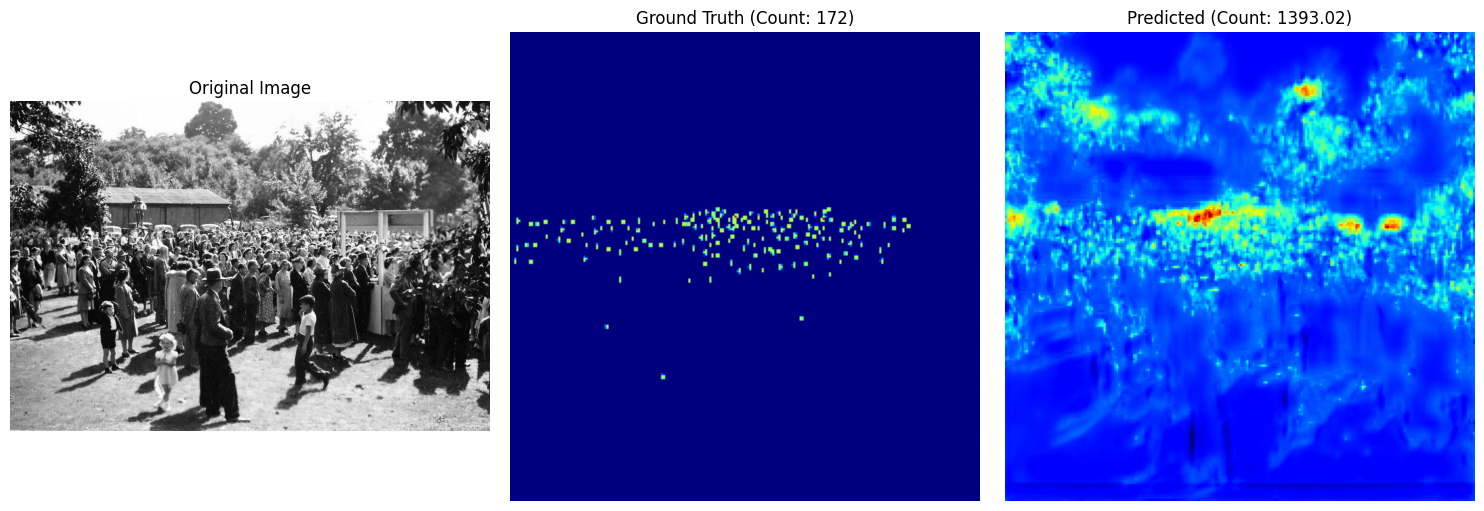

In [ ]:
sample_index = 0
visualize_result(test_images[sample_index], test_gt[sample_index], model)
